# Deep Q-Learning

https://arxiv.org/abs/1312.5602

In [1]:
from copy import deepcopy
from collections import defaultdict

import gymnasium as gym
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F

import mediapy
from livelossplot import PlotLosses

In [2]:
class ReplayBuffer:
    def __init__(self, obs_dim, capacity, device):
        self.obs_buf = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.action_buf = np.zeros((capacity, 1), dtype=np.int64)
        self.reward_buf = np.zeros((capacity, 1), dtype=np.float32)
        self.next_obs_buf = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.done_buf = np.zeros((capacity, 1), dtype=np.int32)
        self.capacity = capacity
        self.device = device
        self.ptr, self.size = 0, 0

    def push(self, obs, action, reward, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.action_buf[self.ptr] = action
        self.reward_buf[self.ptr] = reward
        self.next_obs_buf[self.ptr] = next_obs
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def __len__(self):
        return self.size

    def get_batch(self, batch_size):
        indices = np.random.choice(self.size, batch_size, replace=False)
        return (
            torch.tensor(self.obs_buf[indices], device=self.device),
            torch.tensor(self.action_buf[indices], device=self.device),
            torch.tensor(self.reward_buf[indices], device=self.device),
            torch.tensor(self.next_obs_buf[indices], device=self.device),
            torch.tensor(self.done_buf[indices], device=self.device),
        )

## Models

In [3]:
class QNet(nn.Sequential):
    def __init__(self, obs_dim, action_dim, hidden_size):
        super().__init__(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_dim)
        )


class DQNAgent(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_size, gamma=0.98):
        super().__init__()

        self.action_dim = action_dim
        self.gamma = gamma

        self.q = QNet(obs_dim, action_dim, hidden_size)
        self.q_target = deepcopy(self.q)

    def get_action(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
        q_values = self.q(obs)
        return torch.argmax(q_values).cpu().numpy()

    def compute_loss(self, obs, action, reward, next_obs, done):
        q_values = self.q(obs)
        q_value = q_values.gather(1, action)

        with torch.no_grad():
            next_q_values = self.q_target(next_obs)
            backup = reward + (1 - done) * self.gamma * torch.max(next_q_values, -1, keepdim=True)[0]

        loss = F.mse_loss(q_value, backup)
        info = {
            'q_value': q_value.mean().item(),
        }
        return loss, info

    def update_target(self):
        self.q_target.load_state_dict(self.q.state_dict())

    @property
    def device(self):
        return next(self.parameters()).device

## Train

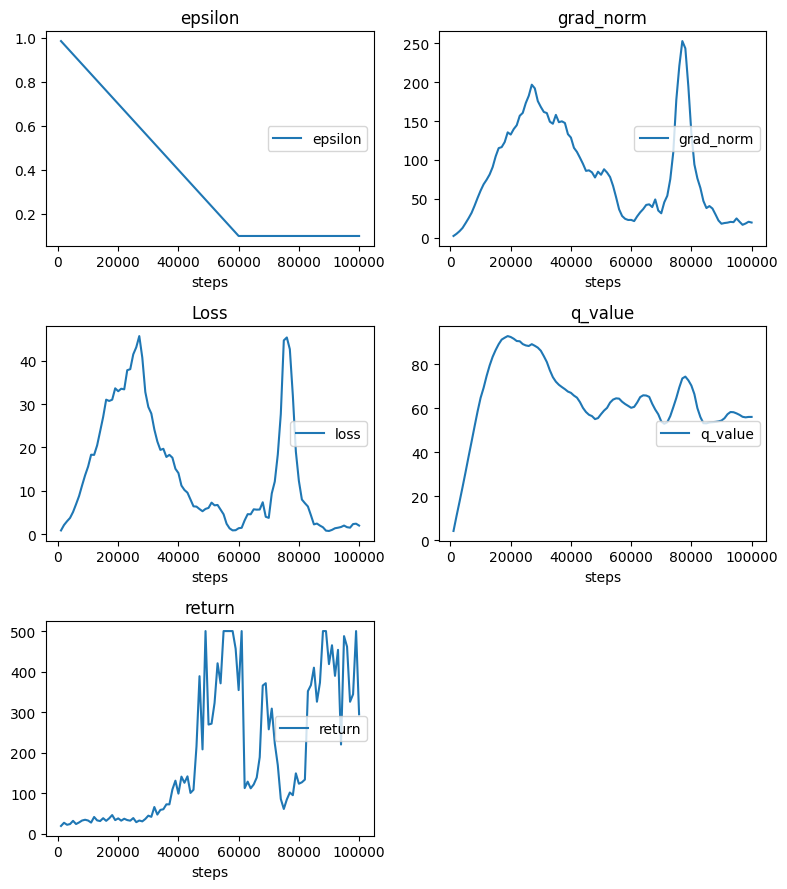

epsilon
	epsilon          	 (min:    0.100, max:    0.985, cur:    0.100)
grad_norm
	grad_norm        	 (min:    2.169, max:  253.084, cur:   19.487)
Loss
	loss             	 (min:    0.710, max:   45.671, cur:    1.956)
q_value
	q_value          	 (min:    4.112, max:   92.703, cur:   55.956)
return
	return           	 (min:   18.940, max:  500.000, cur:  294.667)


In [4]:
hidden_size = 64

gamma = 0.98
learning_rate = 3e-4
gradient_clipping = 10.0

buffer_size = 10000
batch_size = 100

num_steps = 100000

# epsilon schedule
epsilon_max = 1.0
epsilon_min = 0.1
epsilon_min_steps = 60000

target_update_interval = 100
log_interval = 1000

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

env = gym.make('CartPole-v1', render_mode='rgb_array')
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(obs_dim, action_dim, hidden_size, gamma).to(device)
optimizer = optim.Adam(agent.parameters(), lr=learning_rate)
buffer = ReplayBuffer(obs_dim, buffer_size, device)

logs = PlotLosses(figsize=(8, 9), step_names='steps')
stats = defaultdict(list)

obs, _ = env.reset()
ep_return = 0
for step in range(num_steps):
    # Interact with environment with epsilon-greedy policy
    epsilon = epsilon_min + max(0, (epsilon_max - epsilon_min) * (epsilon_min_steps - step) / epsilon_min_steps)
    if np.random.rand() < epsilon:
        action = env.action_space.sample()
    else:
        action = agent.get_action(obs)

    next_obs, reward, terminated, truncated, _ = env.step(action)
    buffer.push(obs, action, reward, next_obs, terminated)
    ep_return += reward
    obs = next_obs

    if terminated or truncated:
        obs, _ = env.reset()
        stats['return'].append(ep_return)
        ep_return = 0

    # Update Q-model
    if len(buffer) >= batch_size:
        batch = buffer.get_batch(batch_size)
        loss, info = agent.compute_loss(*batch)

        optimizer.zero_grad()
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(agent.parameters(), gradient_clipping)
        optimizer.step()

        stats['loss'].append(loss.item())
        stats['q_value'].append(info['q_value'])
        stats['grad_norm'].append(grad_norm.item())

        if step % target_update_interval == 0:
            agent.update_target()

    if (step + 1) % log_interval == 0:
        logs.update({
            'epsilon': epsilon,
            'return': np.mean(stats['return']),
            'loss': np.mean(stats['loss']),
            'q_value': np.mean(stats['q_value']),
            'grad_norm': np.mean(stats['grad_norm']),
        }, current_step=step)
        logs.send()
        stats = defaultdict(list)

## Evaluate

In [5]:
eval_episodes = 30
returns = []
for episode in range(eval_episodes):
    obs, _ = env.reset()
    done = False
    return_ = 0
    while not done:
        act = agent.get_action(obs)
        obs, reward, terminated, truncated, _ = env.step(act)
        done = terminated or truncated
        return_ += reward
    returns.append(return_)

print(f"Average return: {np.mean(returns):.02f}")

Average return: 500.00


## Sample

In [6]:
obs, _ = env.reset()
done = False
frames = [env.render()]
while not done:
    act = agent.get_action(obs)
    obs, _, terminated, truncated, _ = env.step(act)
    done = terminated or truncated
    frames.append(env.render())

mediapy.show_video(frames, fps=30)